In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn import datasets, metrics
import seaborn as sns
import umap

%matplotlib inline

In [2]:
data_path = "/Users/jamesmoss/Documents/GitHub/Capstone/Capstone3/charting-m-points.csv"
data_path = "charting-m-points.csv"

df = pd.read_csv(data_path, encoding="ISO-8859-1")

/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,8,9,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Initial Exploration

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 500)
# df["match_id"].head(5)
df.head(3)

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isRally1st,isRally2nd,Sv1,Sv2,Rally,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,rallyLen,PtWinner,isSvrWinner,PtsAfter,GmW,Gm1.1,Gm2.1,SetW,Set1.1,Set2.1,rallyCount
0,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,1,0,0,0.0,0.0,0-0,1 (1),1,0,NaN,1,2,EG,6n,5b2n@,NaN,0,0.0,0,1.0,0,1,6n,5,b2n@,False,False,False,False,True,False,1,1,1,15-0,0,0,0,0,0,0,1
1,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,2,0,0,0.0,0.0,15-0,1 (2),1,0,NaN,1,2,EG,5b37b3b1r3n#,NaN,NaN,0,NaN,1,NaN,1,0,5,NaN,b37b3b1r3n#,False,False,False,True,False,False,4,2,0,15-15,0,0,0,0,0,0,4
2,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,3,0,0,0.0,0.0,15-15,1 (3),1,0,NaN,1,2,EG,4n,6b28f1n@,NaN,0,0.0,0,1.0,0,1,4n,6,b28f1n@,False,False,False,False,True,False,2,2,0,15-30,0,0,0,0,0,0,2


In [4]:
df[['1st', '2nd']].head(30)

,1st,2nd
0,6n,5b2n@
1,5b37b3b1r3n#,NaN
2,4n,6b28f1n@
3,4b38b3b3b3b3b3b1f3b3b3b1f1f1n@,NaN
4,4n,4f28b2f1f2f1f2b1r2f1f3b2y3*
5,4n,5f38b3b3b3b3b3w@
6,6b2d#,NaN
7,4*,NaN
8,4f1d#,NaN
9,6f2d@,NaN


## Extracting individual shot information

In [5]:
df_shots1=df['1st'].str.extractall(r'([fbrsvzopuylmhijktq]\d{1,2})')
#df_shots2=df['1st'].str.extractall(r'([fbrsvzopuylmhijktq]\d{1,2})').reset_index().pivot(index='level_0', columns='match')
#df_shots.iloc[:, 1::2]

In [6]:
rally_lists=df['2nd'].fillna(df['1st'])
rally_lists=rally_lists.str.split(r'([fbrsvzopuylmhijktq]\d{1,2})')#.str.clear('')
rally_lists=rally_lists.apply(lambda x: [a for a in x if a])
match_rallies=df[['match_id', 'Svr']]
match_rallies['rally_lists']=rally_lists
match_rallies['player1_id']=match_rallies['match_id'].str.split('-').str[-2]
match_rallies['player2_id']=match_rallies['match_id'].str.split('-').str[-1]


/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [7]:
match_rallies.head()

,match_id,Svr,rally_lists,player1_id,player2_id
0,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,1,"[5, b2, n@]",Ernests_Gulbis,Mohamed_Safwat
1,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,1,"[5, b37, b3, b1, r3, n#]",Ernests_Gulbis,Mohamed_Safwat
2,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,1,"[6, b28, f1, n@]",Ernests_Gulbis,Mohamed_Safwat
3,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,1,"[4, b38, b3, b3, b3, b3, b3, b1, f3, b3, b3, b...",Ernests_Gulbis,Mohamed_Safwat
4,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,1,"[4, f28, b2, f1, f2, f1, f2, b1, r2, f1, f3, b...",Ernests_Gulbis,Mohamed_Safwat


In [8]:
def player1_points(rally,server):
    return rally[(1-server)%2::2]
def player2_points(rally,server):
    return rally[server%2::2]


match_rallies['player1_shots']=match_rallies.apply(lambda x: player1_points(x['rally_lists'],x['Svr']), axis=1)
match_rallies['player2_shots']=match_rallies.apply(lambda x: player2_points(x['rally_lists'],x['Svr']), axis=1)



/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
player1_rallies=pd.DataFrame()
player2_rallies=pd.DataFrame()
player1_rallies[['player_id','player_shots',]]=match_rallies[['player1_id','player1_shots',]]
player2_rallies[['player_id','player_shots',]]=match_rallies[['player2_id','player2_shots',]]
all_player_rallies=player1_rallies.append(player2_rallies)
all_player_rallies

,player_id,player_shots
0,Ernests_Gulbis,"[5, n@]"
1,Ernests_Gulbis,"[5, b3, r3]"
2,Ernests_Gulbis,"[6, f1]"
3,Ernests_Gulbis,"[4, b3, b3, b3, f3, b3, f1, n@]"
4,Ernests_Gulbis,"[4, b2, f2, f2, r2, f3, y3]"
...,...,...
439983,Ken_Rosewall,[s3]
439984,Ken_Rosewall,[b3]
439985,Ken_Rosewall,"[s3, d@]"
439986,Ken_Rosewall,"[f1, s#]"


In [28]:
#now create a data set for patterns of two shots
def two_shots(shots_list):
    new_list=[]
    if len(shots_list)>1:
        for i in range(1,len(shots_list)):
            new_list=new_list+[str(shots_list[i-1])+str(shots_list[i])]
        return new_list
    else:
        return shots_list
two_shot_patterns=all_player_rallies[['player_id']]
two_shot_patterns['player_patterns2']=all_player_rallies['player_shots'].apply(lambda x: two_shots(x))

In [29]:
two_shot_patterns.head()

,player_id,player_patterns2
0,Ernests_Gulbis,[5n@]
1,Ernests_Gulbis,"[5b3, b3r3]"
2,Ernests_Gulbis,[6f1]
3,Ernests_Gulbis,"[4b3, b3b3, b3b3, b3f3, f3b3, b3f1, f1n@]"
4,Ernests_Gulbis,"[4b2, b2f2, f2f2, f2r2, r2f3, f3y3]"


In [10]:
#separate each item in the rally list into it's own row
patterns1=all_player_rallies.explode('player_shots')
#find total number of shots:
print(pd.crosstab(index=patterns1['player_id'], columns=patterns1['player_shots']).sum().sum())
#this should take out most points that were coded incorrectly
patterns1=patterns1[patterns1['player_shots'].apply(lambda x: len(str(x))<5)]

2357657


In [11]:
tabulated_patterns1=pd.crosstab(index=patterns1['player_id'], columns=patterns1['player_shots'])#, normalize='index')


In [12]:
tabulated_patterns1=tabulated_patterns1.drop([col for col, val in tabulated_patterns1.median().iteritems() if val < 2], axis=1)
#final total of shots:
tabulated_patterns1.sum().sum()


2094014

In [13]:
tabulated_patterns1=tabulated_patterns1.div(tabulated_patterns1.sum(axis=1), axis=0)

In [14]:
tabulated_patterns1.head()

player_shots,*,4,4*,4+,5,6,6*,b1,b17,b18,b19,b2,b27,b28,b29,b3,b37,b38,b39,d#,d@,f+1,f+3,f1,f17,f18,f19,f2,f27,f28,f29,f3,f37,f38,f39,m2,m3,n#,n@,o1,r1,r2,r3,s1,s2,s27,s28,s3,v1,v3,w#,w@,x#,z1,z2,z3
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron_Krickstein,0.053221,0.047619,0.002801,0.001681,0.034174,0.038095,0.005042,0.025770,0.001681,0.004482,0.001681,0.058263,0.007843,0.022409,0.002801,0.135574,0.012885,0.018487,0.001681,0.010644,0.013445,0.006162,0.006162,0.135014,0.003361,0.011765,0.001120,0.060504,0.003361,0.008964,0.003361,0.095798,0.001120,0.001681,0.000000,0.003922,0.002801,0.014566,0.019048,0.001120,0.003361,0.000560,0.001120,0.011765,0.012885,0.001681,0.000560,0.040336,0.001681,0.004482,0.008403,0.019608,0.001681,0.006162,0.001120,0.004482
Adam_Pavlasek,0.026467,0.072497,0.009206,0.003452,0.036824,0.058688,0.016110,0.034522,0.001151,0.001151,0.002301,0.072497,0.008055,0.035673,0.012658,0.105869,0.013809,0.011507,0.003452,0.024166,0.024166,0.009206,0.017261,0.078251,0.001151,0.002301,0.003452,0.062140,0.004603,0.008055,0.003452,0.077100,0.001151,0.002301,0.000000,0.003452,0.000000,0.013809,0.033372,0.002301,0.002301,0.009206,0.003452,0.001151,0.003452,0.002301,0.005754,0.039125,0.002301,0.005754,0.008055,0.009206,0.000000,0.008055,0.000000,0.002301
Adrian_Mannarino,0.033807,0.049432,0.007102,0.002273,0.036648,0.049716,0.005398,0.125000,0.005682,0.008239,0.005966,0.075000,0.009943,0.011932,0.011080,0.044886,0.001136,0.003693,0.002841,0.008523,0.016193,0.000852,0.001989,0.040625,0.001705,0.001989,0.002557,0.074148,0.008239,0.015909,0.006534,0.196591,0.003125,0.003409,0.003693,0.003125,0.002841,0.019602,0.031534,0.001136,0.000568,0.002273,0.002841,0.002841,0.008807,0.001705,0.001136,0.010227,0.002557,0.001705,0.007386,0.017045,0.001136,0.003409,0.001136,0.001136
Adriano_Panatta,0.074713,0.113027,0.000000,0.017241,0.032567,0.003831,0.003831,0.019157,0.000000,0.000000,0.000000,0.022989,0.005747,0.000000,0.001916,0.038314,0.001916,0.003831,0.000000,0.021073,0.013410,0.009579,0.017241,0.076628,0.005747,0.003831,0.000000,0.078544,0.001916,0.022989,0.007663,0.049808,0.001916,0.003831,0.000000,0.024904,0.003831,0.019157,0.013410,0.003831,0.003831,0.003831,0.001916,0.015326,0.055556,0.009579,0.009579,0.105364,0.009579,0.003831,0.021073,0.005747,0.001916,0.013410,0.009579,0.011494
Adrien_Bossel,0.032967,0.043956,0.005495,0.000000,0.032967,0.126374,0.000000,0.126374,0.000000,0.016484,0.000000,0.049451,0.000000,0.000000,0.021978,0.060440,0.000000,0.000000,0.000000,0.000000,0.005495,0.016484,0.010989,0.027473,0.005495,0.000000,0.000000,0.054945,0.000000,0.021978,0.010989,0.137363,0.000000,0.021978,0.005495,0.000000,0.000000,0.049451,0.021978,0.000000,0.005495,0.005495,0.010989,0.005495,0.005495,0.000000,0.010989,0.005495,0.000000,0.000000,0.010989,0.000000,0.005495,0.005495,0.005495,0.016484


In [31]:
#now do the above for the dataset containing the two-shot patterns:

#separate each item in the rally list into it's own row
patterns2=two_shot_patterns.explode('player_patterns2')
#find total number of shots:
print(pd.crosstab(index=patterns2['player_id'], columns=patterns2['player_patterns2']).sum().sum())
#this should take out most points that were coded incorrectly
patterns2=patterns2[patterns2['player_patterns2'].apply(lambda x: len(str(x))<8)]

tabulated_patterns2=pd.crosstab(index=patterns2['player_id'], columns=patterns2['player_patterns2'])#, normalize='index')
tabulated_patterns2=tabulated_patterns2.drop([col for col, val in tabulated_patterns2.median().iteritems() if val < 2], axis=1)
tabulated_patterns2=tabulated_patterns2.div(tabulated_patterns2.sum(axis=1), axis=0)

1721941


In [32]:
tabulated_patterns2.head()

player_patterns2,4*,4b1,4b2,4b3,4d#,4f1,4f2,4f3,4n#,4w#,5b2,5b3,5f1,5f2,5f3,6*,6b2,6b3,6d#,6f1,6f2,6f3,6n#,b1,b1f1,b1f3,b2,b2*,b2b1,b2b2,b2b3,b2f1,b2f2,b2f3,b3,b3*,b3b1,b3b2,b3b3,b3f1,b3f2,b3f3,b3n@,f1,f1*,f1b2,f1b3,f1d@,f1f1,f1f2,f1f3,f1n@,f2,f2*,f2b1,f2b2,f2b3,f2f1,f2f2,f2f3,f3,f3*,f3b1,f3b2,f3b3,f3f1,f3f2,f3f3
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron_Krickstein,0.007509,0.001252,0.011264,0.015019,0.003755,0.033792,0.011264,0.007509,0.003755,0.001252,0.007509,0.023780,0.012516,0.006258,0.016270,0.011264,0.003755,0.013767,0.003755,0.012516,0.010013,0.017522,0.002503,0.007509,0.010013,0.005006,0.007509,0.002503,0.003755,0.013767,0.022528,0.020025,0.012516,0.010013,0.010013,0.011264,0.012516,0.022528,0.063830,0.038798,0.023780,0.023780,0.005006,0.018773,0.005006,0.012516,0.036295,0.007509,0.048811,0.025031,0.042553,0.002503,0.002503,0.006258,0.003755,0.010013,0.026283,0.021277,0.008761,0.015019,0.008761,0.005006,0.006258,0.006258,0.027534,0.035044,0.015019,0.038798
Adam_Pavlasek,0.030581,0.009174,0.015291,0.033639,0.015291,0.009174,0.009174,0.030581,0.009174,0.003058,0.012232,0.009174,0.009174,0.009174,0.024465,0.042813,0.009174,0.009174,0.009174,0.024465,0.015291,0.033639,0.009174,0.012232,0.012232,0.003058,0.033639,0.003058,0.006116,0.012232,0.027523,0.015291,0.015291,0.018349,0.009174,0.000000,0.012232,0.030581,0.058104,0.024465,0.006116,0.018349,0.009174,0.009174,0.000000,0.009174,0.000000,0.006116,0.018349,0.021407,0.021407,0.006116,0.015291,0.009174,0.003058,0.018349,0.024465,0.012232,0.012232,0.006116,0.000000,0.000000,0.006116,0.009174,0.045872,0.006116,0.012232,0.018349
Adrian_Mannarino,0.018704,0.020708,0.008016,0.006680,0.006680,0.010688,0.004676,0.020040,0.011356,0.003340,0.009352,0.005344,0.002672,0.013360,0.024048,0.014696,0.007348,0.003340,0.003340,0.007348,0.014696,0.034068,0.006012,0.009352,0.007348,0.037408,0.010688,0.004676,0.028724,0.016700,0.003340,0.003340,0.020708,0.036740,0.006012,0.001336,0.009352,0.001336,0.004008,0.006012,0.008684,0.027388,0.004676,0.007348,0.001336,0.006680,0.008684,0.000000,0.003340,0.004008,0.012024,0.001336,0.012024,0.008016,0.018704,0.022712,0.006012,0.004676,0.015364,0.031396,0.006680,0.004008,0.051436,0.022044,0.018036,0.023380,0.034736,0.171677
Adriano_Panatta,0.000000,0.000000,0.036585,0.012195,0.048780,0.036585,0.036585,0.024390,0.024390,0.012195,0.000000,0.000000,0.036585,0.012195,0.000000,0.024390,0.000000,0.000000,0.012195,0.000000,0.000000,0.012195,0.000000,0.000000,0.000000,0.012195,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.048780,0.000000,0.012195,0.024390,0.000000,0.012195,0.024390,0.012195,0.024390,0.000000,0.000000,0.048780,0.024390,0.000000,0.000000,0.000000,0.024390,0.012195,0.012195,0.012195,0.024390,0.036585,0.024390,0.000000,0.024390,0.012195,0.060976,0.073171,0.036585,0.012195,0.012195,0.000000,0.012195,0.000000,0.012195,0.000000
Adrien_Bossel,0.018182,0.018182,0.000000,0.036364,0.000000,0.000000,0.000000,0.036364,0.018182,0.000000,0.000000,0.018182,0.000000,0.000000,0.036364,0.000000,0.018182,0.036364,0.000000,0.036364,0.000000,0.109091,0.018182,0.000000,0.000000,0.036364,0.036364,0.018182,0.018182,0.000000,0.000000,0.000000,0.000000,0.018182,0.018182,0.000000,0.018182,0.000000,0.000000,0.018182,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.018182,0.018182,0.018182,0.036364,0.000000,0.000000,0.018182,0.036364,0.018182,0.036364,0.000000,0.000000,0.036364,0.036364,0.090909


## Automatically created contextual shot dataset

In [20]:
data_path3='/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone3/charting-m-stats-ShotDirOutcomesFixed.csv'
df3=pd.read_csv(data_path3)

In [21]:
df3['player_id']=None
df3.loc[df3['player']==2, ['player_id']]=df3["match_id"].str.split("-").str[-1]
df3.loc[df3['player']==1, ['player_id']]=df3["match_id"].str.split("-").str[-2]
df3['opponent_id']=None
df3.loc[df3['player']==2, ['opponent_id']]=df3["match_id"].str.split("-").str[-2]
df3.loc[df3['player']==1, ['opponent_id']]=df3["match_id"].str.split("-").str[-1]
df3['stroke']=df3['row'].str[0]
df3['shot_style']=df3['row'].str[2:]

df3_clean=df3.drop(columns=['match_id', 'player'])

#pd.get_dummies(df3_clean)


In [22]:
df3_clean.head(5)

,row,shots,pt_ending,winners,induced_forced,unforced,shots_in_pts_won,shots_in_pts_lost,player_id,opponent_id,stroke,shot_style
0,F-XC,27,6,2,3,1,17,10,Bjorn_Borg,Jiri_Hrebec,F,XC
1,F-DTM,23,0,0,0,0,15,8,Bjorn_Borg,Jiri_Hrebec,F,DTM
2,F-DTL,10,1,1,0,0,5,5,Bjorn_Borg,Jiri_Hrebec,F,DTL
3,F-IO,19,1,0,1,0,11,8,Bjorn_Borg,Jiri_Hrebec,F,IO
4,B-XC,57,6,3,1,2,36,21,Bjorn_Borg,Jiri_Hrebec,B,XC


## Overview stats dataset

In [45]:
data_path4='/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone3/charting-m-stats-Overview.csv'
df4=pd.read_csv(data_path4)

In [46]:
df4 = df4[df4["set"] == "Total"]
df4=df4.drop(columns=['set'])

df4['player_id']=None
df4.loc[df4['player']==2, ['player_id']]=df4["match_id"].str.split("-").str[-1]
df4.loc[df4['player']==1, ['player_id']]=df4["match_id"].str.split("-").str[-2]
df4["year"] = df4["match_id"].str[0:4].astype(int)

df4=df4.drop(columns=['match_id', 'player'])

#df4["matches_no"] = 1
player_count=df4[['player_id']]
player_count['matches_number']=1
player_count = player_count.groupby("player_id").sum()

df4 = df4.groupby("player_id").mean()


df4["serve_pts"] = df4["serve_pts"] + df4["dfs"]
df4["first_out"] = df4["serve_pts"] - df4["first_in"]
df4["first_make_pct"] = df4["first_in"] / df4["serve_pts"]
df4["first_win_pct"] = df4["first_won"] / df4["first_in"]
df4["first_make_win"] = df4["first_make_pct"] * df4["first_win_pct"]

df4["second_total"] = df4["second_in"] + df4["dfs"]
#df4["second_out"] = df4["dfs"]
df4["second_make_pct"] = df4["second_in"] / df4["second_total"]
df4["second_win_pct"] = df4["second_won"] / df4["second_in"]
df4["second_make_win"] = df4["second_make_pct"] * df4["second_win_pct"]
#this is the likelihood of winning the point on your second serve before you hit your first
df4['second_success']= df4['second_make_win'] * (1-df4['first_make_pct'])
df4['matches_number']=player_count['matches_number']#
df4=df4[df4['matches_number']>1]#
df4=df4.drop(columns='matches_number')#

/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [47]:
display(df4.head())
display(player_count.value_counts())
df4.shape

,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,bk_pts,bp_saved,return_pts,return_pts_won,winners,winners_fh,winners_bh,unforced,unforced_fh,unforced_bh,year,first_out,first_make_pct,first_win_pct,first_make_win,second_total,second_make_pct,second_win_pct,second_make_win,second_success
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron_Krickstein,71.250000,3.750000,1.000000,36.500000,21.000000,33.750000,14.750000,8.500000,2.500000,70.750000,23.750000,16.000000,6.750000,5.500,23.000000,10.000000,12.000000,1991.750000,34.750000,0.512281,0.575342,0.294737,34.750000,0.971223,0.437037,0.424460,0.207018
Adam_Pavlasek,64.333333,7.333333,1.666667,34.000000,25.000000,28.666667,14.000000,7.666667,5.333333,58.666667,21.666667,17.666667,7.333333,3.000,30.333333,13.000000,15.666667,2018.000000,30.333333,0.528497,0.735294,0.388601,30.333333,0.945055,0.488372,0.461538,0.217617
Adrian_Mannarino,75.875000,5.625000,1.625000,47.750000,32.125000,26.500000,13.375000,7.500000,4.125000,76.125000,27.750000,17.000000,5.375000,5.375,27.625000,14.375000,11.625000,2017.875000,28.125000,0.629325,0.672775,0.423394,28.125000,0.942222,0.504717,0.475556,0.176277
Albert_Costa,101.333333,1.666667,3.000000,65.333333,40.666667,33.000000,16.000000,10.000000,4.666667,101.666667,49.666667,42.000000,30.333333,10.000,40.333333,18.666667,18.666667,1998.666667,36.000000,0.644737,0.622449,0.401316,36.000000,0.916667,0.484848,0.444444,0.157895
Albert_Montanes,50.666667,1.666667,3.666667,26.333333,14.333333,20.666667,6.666667,8.333333,3.333333,49.666667,17.000000,13.000000,8.333333,3.000,22.666667,12.666667,6.333333,2011.666667,24.333333,0.519737,0.544304,0.282895,24.333333,0.849315,0.322581,0.273973,0.131579


matches_number
1                 213
2                  79
3                  41
4                  22
5                  21
7                  20
8                  14
6                  11
12                 10
10                 10
9                   9
16                  8
17                  8
13                  6
25                  6
15                  6
24                  5
11                  4
14                  3
20                  3
18                  3
37                  3
30                  2
50                  2
32                  2
39                  2
45                  2
51                  2
23                  2
21                  1
22                  1
442                 1
27                  1
269                 1
263                 1
151                 1
128                 1
109                 1
104                 1
97                  1
83                  1
69                  1
62                  1
60                  1
56               

(329, 27)

## Combining summary statistics with individual shot data

In [27]:
#Now merge the summary statistics with the rally statistics above
df_merged=df4.merge(tabulated_patterns1, how='left', on='player_id')

In [28]:
df_merged.shape

(329, 83)

In [51]:
df_merged.head()

,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,bk_pts,bp_saved,return_pts,return_pts_won,winners,winners_fh,winners_bh,unforced,unforced_fh,unforced_bh,year,first_out,first_make_pct,first_win_pct,first_make_win,second_total,second_make_pct,second_win_pct,second_make_win,second_success,*,4,4*,4+,5,6,6*,b1,b17,b18,b19,b2,b27,b28,b29,b3,b37,b38,b39,d#,d@,f+1,f+3,f1,f17,f18,f19,f2,f27,f28,f29,f3,f37,f38,f39,m2,m3,n#,n@,o1,r1,r2,r3,s1,s2,s27,s28,s3,v1,v3,w#,w@,x#,z1,z2,z3,Cluster
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron_Krickstein,71.250000,3.750000,1.000000,36.500000,21.000000,33.750000,14.750000,8.500000,2.500000,70.750000,23.750000,16.000000,6.750000,5.500,23.000000,10.000000,12.000000,1991.750000,34.750000,0.512281,0.575342,0.294737,34.750000,0.971223,0.437037,0.424460,0.207018,0.053221,0.047619,0.002801,0.001681,0.034174,0.038095,0.005042,0.025770,0.001681,0.004482,0.001681,0.058263,0.007843,0.022409,0.002801,0.135574,0.012885,0.018487,0.001681,0.010644,0.013445,0.006162,0.006162,0.135014,0.003361,0.011765,0.001120,0.060504,0.003361,0.008964,0.003361,0.095798,0.001120,0.001681,0.000000,0.003922,0.002801,0.014566,0.019048,0.001120,0.003361,0.000560,0.001120,0.011765,0.012885,0.001681,0.000560,0.040336,0.001681,0.004482,0.008403,0.019608,0.001681,0.006162,0.001120,0.004482,0
Adam_Pavlasek,64.333333,7.333333,1.666667,34.000000,25.000000,28.666667,14.000000,7.666667,5.333333,58.666667,21.666667,17.666667,7.333333,3.000,30.333333,13.000000,15.666667,2018.000000,30.333333,0.528497,0.735294,0.388601,30.333333,0.945055,0.488372,0.461538,0.217617,0.026467,0.072497,0.009206,0.003452,0.036824,0.058688,0.016110,0.034522,0.001151,0.001151,0.002301,0.072497,0.008055,0.035673,0.012658,0.105869,0.013809,0.011507,0.003452,0.024166,0.024166,0.009206,0.017261,0.078251,0.001151,0.002301,0.003452,0.062140,0.004603,0.008055,0.003452,0.077100,0.001151,0.002301,0.000000,0.003452,0.000000,0.013809,0.033372,0.002301,0.002301,0.009206,0.003452,0.001151,0.003452,0.002301,0.005754,0.039125,0.002301,0.005754,0.008055,0.009206,0.000000,0.008055,0.000000,0.002301,0
Adrian_Mannarino,75.875000,5.625000,1.625000,47.750000,32.125000,26.500000,13.375000,7.500000,4.125000,76.125000,27.750000,17.000000,5.375000,5.375,27.625000,14.375000,11.625000,2017.875000,28.125000,0.629325,0.672775,0.423394,28.125000,0.942222,0.504717,0.475556,0.176277,0.033807,0.049432,0.007102,0.002273,0.036648,0.049716,0.005398,0.125000,0.005682,0.008239,0.005966,0.075000,0.009943,0.011932,0.011080,0.044886,0.001136,0.003693,0.002841,0.008523,0.016193,0.000852,0.001989,0.040625,0.001705,0.001989,0.002557,0.074148,0.008239,0.015909,0.006534,0.196591,0.003125,0.003409,0.003693,0.003125,0.002841,0.019602,0.031534,0.001136,0.000568,0.002273,0.002841,0.002841,0.008807,0.001705,0.001136,0.010227,0.002557,0.001705,0.007386,0.017045,0.001136,0.003409,0.001136,0.001136,0
Albert_Costa,101.333333,1.666667,3.000000,65.333333,40.666667,33.000000,16.000000,10.000000,4.666667,101.666667,49.666667,42.000000,30.333333,10.000,40.333333,18.666667,18.666667,1998.666667,36.000000,0.644737,0.622449,0.401316,36.000000,0.916667,0.484848,0.444444,0.157895,0.033071,0.092388,0.000525,0.000000,0.022572,0.025722,0.002100,0.040420,0.000525,0.008399,0.001575,0.058268,0.002625,0.011549,0.007349,0.098163,0.006299,0.016273,0.000000,0.008924,0.015223,0.008924,0.007349,0.168504,0.005249,0.012073,0.001575,0.058793,0.002625,0.015748,0.001050,0.108661,0.002625,0.006824,0.000000,0.002625,0.001050,0.014173,0.023622,0.006824,0.003675,0.004724,0.002100,0.010499,0.006299,0.002100,0.010499,0.022572,0.001575,0.002625,0.013123,0.012598,0.002100,0.003150,0.001050,0.001050,0
Albert_Montanes,50.666667,1.666667,3.666667,26.333333,14.333333,20.666667,6.666667,8.333333,3.333333,49.666667,17.000000,13.000000,8.333333,3.000,22.666667,12.666667,6.333333,2011.666667,24.333333,0.519737,0.544304,0.282895,24.333333,0.849315,0.322581,0.273973,0.131579,0.046095,0.075544,0.005122,0.

## Clustering based on outcome statistics and shot choice

In [30]:
#could optionally drop year from df4, also could only use players with a certain number of matches
scaler=StandardScaler()
df4_std=scaler.fit_transform(df_merged)
pca=PCA(n_components=30)
df4_pca=pca.fit_transform(df4_std)

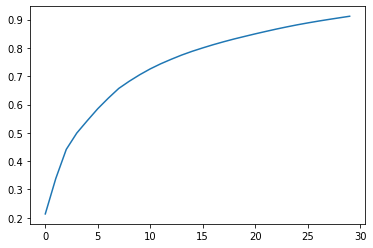

In [31]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [32]:
#looking at groups using only the summary statistics
scaler=StandardScaler()
df4_std=scaler.fit_transform(df4)
pca=PCA(n_components=10)
df4_pca=pca.fit_transform(df4_std)
for c in range(2,16):
    agg_cluster=AgglomerativeClustering(n_clusters=c, linkage='ward')
    clusters = agg_cluster.fit_predict(df4_pca)
    print("The silhoutte score of the {} Agglomerative Clustering solution: {}"
          .format(c,metrics.silhouette_score(df4_std, clusters, metric='euclidean')))
    labels = KMeans(n_clusters=c, random_state=1).fit_predict(df4_pca)
    print("The silhoutte score of the {} KMeans solution: {}"
          .format(c,metrics.silhouette_score(df4_std, labels, metric='euclidean')))


The silhoutte score of the 2 Agglomerative Clustering solution: 0.2552884157264829
The silhoutte score of the 2 KMeans solution: 0.2561600008834521
The silhoutte score of the 3 Agglomerative Clustering solution: 0.13519100722899158
The silhoutte score of the 3 KMeans solution: 0.1603141061139702
The silhoutte score of the 4 Agglomerative Clustering solution: 0.12267395030289442
The silhoutte score of the 4 KMeans solution: 0.1383208627202847
The silhoutte score of the 5 Agglomerative Clustering solution: 0.11987840577121515
The silhoutte score of the 5 KMeans solution: 0.12175615199150867
The silhoutte score of the 6 Agglomerative Clustering solution: 0.08259628875190454
The silhoutte score of the 6 KMeans solution: 0.11772365844707415
The silhoutte score of the 7 Agglomerative Clustering solution: 0.08220973767024664
The silhoutte score of the 7 KMeans solution: 0.12345669519621412
The silhoutte score of the 8 Agglomerative Clustering solution: 0.08856074213263473
The silhoutte score 

It seems like K means generally does better above.

In [33]:
#now looking at groups using the pattern data
scaler=StandardScaler()
df4_std=scaler.fit_transform(df_merged)
pca=PCA(n_components=30)
df4_pca=pca.fit_transform(df4_std)
for c in range(2,16):
    agg_cluster=AgglomerativeClustering(n_clusters=c, linkage='ward')
    clusters = agg_cluster.fit_predict(df4_pca)
    print("The silhoutte score of the {} Agglomerative Clustering solution: {}"
          .format(c,metrics.silhouette_score(df4_std, clusters, metric='euclidean')))
    labels = KMeans(n_clusters=c, random_state=1).fit_predict(df4_pca)
    print("The silhoutte score of the {} KMeans solution: {}"
          .format(c,metrics.silhouette_score(df4_std, labels, metric='euclidean')))


The silhoutte score of the 2 Agglomerative Clustering solution: 0.2928997583542502
The silhoutte score of the 2 KMeans solution: 0.20019008222085355
The silhoutte score of the 3 Agglomerative Clustering solution: 0.13200468257481
The silhoutte score of the 3 KMeans solution: 0.14870698737289878
The silhoutte score of the 4 Agglomerative Clustering solution: 0.10527279205714077
The silhoutte score of the 4 KMeans solution: 0.1186130988578965
The silhoutte score of the 5 Agglomerative Clustering solution: 0.058893606787608556
The silhoutte score of the 5 KMeans solution: 0.09453486009170671
The silhoutte score of the 6 Agglomerative Clustering solution: 0.06797867172319048
The silhoutte score of the 6 KMeans solution: 0.06956601304127047
The silhoutte score of the 7 Agglomerative Clustering solution: 0.05245428183402387
The silhoutte score of the 7 KMeans solution: 0.06601428928158547
The silhoutte score of the 8 Agglomerative Clustering solution: 0.046808515133033454
The silhoutte score

Looks like the 2 clusters for hierarchical clustering was the best

DBSCAN doesn't appear to work so well:

In [81]:
#TODO fix this
es=[.1,.5,3,4.5,5,6,7,8,9,10]
for e in es:
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=e, min_samples=5)
    # Fit model
    clusters = dbscan_cluster.fit_predict(tabulated_patterns1)
#     print("The silhoutte score of the {} DBSCAN solution: {}"
#         .format(e,metrics.silhouette_score(df4_std, clusters, metric='euclidean')))
    print(e)
    display(pd.DataFrame(clusters).value_counts())
#format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

3


0    553
dtype: int64

4.5


0    553
dtype: int64

5


0    553
dtype: int64

6


0    553
dtype: int64

7


0    553
dtype: int64

8


0    553
dtype: int64

9


0    553
dtype: int64

10


0    553
dtype: int64

Getting our cluster labels for the best clustering method:

In [38]:
scaler=StandardScaler()
df4_std=scaler.fit_transform(df_merged)
pca=PCA(n_components=30)
df4_pca=pca.fit_transform(df4_std)
c=2
agg_cluster=AgglomerativeClustering(n_clusters=c, linkage='ward')
clusters = agg_cluster.fit_predict(df4_pca)
print("The silhoutte score of the {} Agglomerative Clustering solution: {}"
      .format(c,metrics.silhouette_score(df4_std, clusters, metric='euclidean')))
labels = KMeans(n_clusters=c, random_state=1).fit_predict(df4_pca)
print("The silhoutte score of the {} KMeans solution: {}"
      .format(c,metrics.silhouette_score(df4_std, labels, metric='euclidean')))


The silhoutte score of the 2 Agglomerative Clustering solution: 0.2928997583542502
The silhoutte score of the 2 KMeans solution: 0.20019008222085355


## Analyzing/Visualizing Clusters

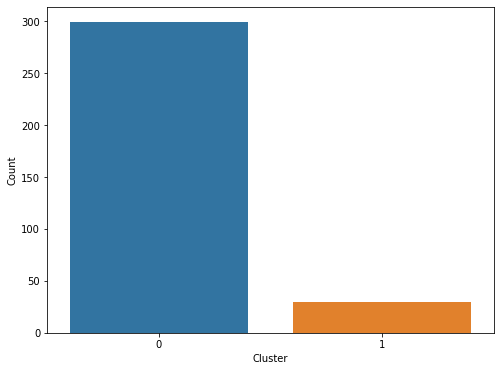

In [39]:
plt.figure(figsize=(8,6))
sns.barplot(data=pd.DataFrame(clusters).value_counts())
plt.ylabel("Count")
plt.xlabel("Cluster")
plt.show()

In [40]:
#creating a label column
df_merged['Cluster']=clusters

In [41]:
df_merged.head()

,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,bk_pts,bp_saved,return_pts,return_pts_won,winners,winners_fh,winners_bh,unforced,unforced_fh,unforced_bh,year,first_out,first_make_pct,first_win_pct,first_make_win,second_total,second_make_pct,second_win_pct,second_make_win,second_success,*,4,4*,4+,5,6,6*,b1,b17,b18,b19,b2,b27,b28,b29,b3,b37,b38,b39,d#,d@,f+1,f+3,f1,f17,f18,f19,f2,f27,f28,f29,f3,f37,f38,f39,m2,m3,n#,n@,o1,r1,r2,r3,s1,s2,s27,s28,s3,v1,v3,w#,w@,x#,z1,z2,z3,Cluster
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron_Krickstein,71.250000,3.750000,1.000000,36.500000,21.000000,33.750000,14.750000,8.500000,2.500000,70.750000,23.750000,16.000000,6.750000,5.500,23.000000,10.000000,12.000000,1991.750000,34.750000,0.512281,0.575342,0.294737,34.750000,0.971223,0.437037,0.424460,0.207018,0.053221,0.047619,0.002801,0.001681,0.034174,0.038095,0.005042,0.025770,0.001681,0.004482,0.001681,0.058263,0.007843,0.022409,0.002801,0.135574,0.012885,0.018487,0.001681,0.010644,0.013445,0.006162,0.006162,0.135014,0.003361,0.011765,0.001120,0.060504,0.003361,0.008964,0.003361,0.095798,0.001120,0.001681,0.000000,0.003922,0.002801,0.014566,0.019048,0.001120,0.003361,0.000560,0.001120,0.011765,0.012885,0.001681,0.000560,0.040336,0.001681,0.004482,0.008403,0.019608,0.001681,0.006162,0.001120,0.004482,0
Adam_Pavlasek,64.333333,7.333333,1.666667,34.000000,25.000000,28.666667,14.000000,7.666667,5.333333,58.666667,21.666667,17.666667,7.333333,3.000,30.333333,13.000000,15.666667,2018.000000,30.333333,0.528497,0.735294,0.388601,30.333333,0.945055,0.488372,0.461538,0.217617,0.026467,0.072497,0.009206,0.003452,0.036824,0.058688,0.016110,0.034522,0.001151,0.001151,0.002301,0.072497,0.008055,0.035673,0.012658,0.105869,0.013809,0.011507,0.003452,0.024166,0.024166,0.009206,0.017261,0.078251,0.001151,0.002301,0.003452,0.062140,0.004603,0.008055,0.003452,0.077100,0.001151,0.002301,0.000000,0.003452,0.000000,0.013809,0.033372,0.002301,0.002301,0.009206,0.003452,0.001151,0.003452,0.002301,0.005754,0.039125,0.002301,0.005754,0.008055,0.009206,0.000000,0.008055,0.000000,0.002301,0
Adrian_Mannarino,75.875000,5.625000,1.625000,47.750000,32.125000,26.500000,13.375000,7.500000,4.125000,76.125000,27.750000,17.000000,5.375000,5.375,27.625000,14.375000,11.625000,2017.875000,28.125000,0.629325,0.672775,0.423394,28.125000,0.942222,0.504717,0.475556,0.176277,0.033807,0.049432,0.007102,0.002273,0.036648,0.049716,0.005398,0.125000,0.005682,0.008239,0.005966,0.075000,0.009943,0.011932,0.011080,0.044886,0.001136,0.003693,0.002841,0.008523,0.016193,0.000852,0.001989,0.040625,0.001705,0.001989,0.002557,0.074148,0.008239,0.015909,0.006534,0.196591,0.003125,0.003409,0.003693,0.003125,0.002841,0.019602,0.031534,0.001136,0.000568,0.002273,0.002841,0.002841,0.008807,0.001705,0.001136,0.010227,0.002557,0.001705,0.007386,0.017045,0.001136,0.003409,0.001136,0.001136,0
Albert_Costa,101.333333,1.666667,3.000000,65.333333,40.666667,33.000000,16.000000,10.000000,4.666667,101.666667,49.666667,42.000000,30.333333,10.000,40.333333,18.666667,18.666667,1998.666667,36.000000,0.644737,0.622449,0.401316,36.000000,0.916667,0.484848,0.444444,0.157895,0.033071,0.092388,0.000525,0.000000,0.022572,0.025722,0.002100,0.040420,0.000525,0.008399,0.001575,0.058268,0.002625,0.011549,0.007349,0.098163,0.006299,0.016273,0.000000,0.008924,0.015223,0.008924,0.007349,0.168504,0.005249,0.012073,0.001575,0.058793,0.002625,0.015748,0.001050,0.108661,0.002625,0.006824,0.000000,0.002625,0.001050,0.014173,0.023622,0.006824,0.003675,0.004724,0.002100,0.010499,0.006299,0.002100,0.010499,0.022572,0.001575,0.002625,0.013123,0.012598,0.002100,0.003150,0.001050,0.001050,0
Albert_Montanes,50.666667,1.666667,3.666667,26.333333,14.333333,20.666667,6.666667,8.333333,3.333333,49.666667,17.000000,13.000000,8.333333,3.000,22.666667,12.666667,6.333333,2011.666667,24.333333,0.519737,0.544304,0.282895,24.333333,0.849315,0.322581,0.273973,0.131579,0.046095,0.075544,0.005122,0.

In [42]:
df_merged.groupby('Cluster').mean().style.background_gradient(axis=1)

,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,bk_pts,bp_saved,return_pts,return_pts_won,winners,winners_fh,winners_bh,unforced,unforced_fh,unforced_bh,year,first_out,first_make_pct,first_win_pct,first_make_win,second_total,second_make_pct,second_win_pct,second_make_win,second_success,*,4,4*,4+,5,6,6*,b1,b17,b18,b19,b2,b27,b28,b29,b3,b37,b38,b39,d#,d@,f+1,f+3,f1,f17,f18,f19,f2,f27,f28,f29,f3,f37,f38,f39,m2,m3,n#,n@,o1,r1,r2,r3,s1,s2,s27,s28,s3,v1,v3,w#,w@,x#,z1,z2,z3
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,82.111642,5.492691,2.950142,48.397361,33.367904,30.764139,15.112901,7.489638,4.352569,77.745987,27.497320,24.021713,11.516468,6.211996,28.680474,13.804403,11.925930,2012.529394,33.714281,0.589591,0.688196,0.405605,33.714281,0.913179,0.489514,0.447863,0.183192,0.040307,0.067321,0.006358,0.005446,0.039534,0.053017,0.007587,0.040413,0.002464,0.005299,0.003433,0.059296,0.007875,0.018236,0.011171,0.085171,0.007081,0.013616,0.006424,0.016558,0.018595,0.004302,0.007414,0.095174,0.004411,0.009790,0.005807,0.059467,0.006939,0.014906,0.009270,0.087234,0.003806,0.009095,0.005624,0.002894,0.001845,0.021710,0.023550,0.001843,0.002754,0.005731,0.003253,0.008869,0.016138,0.002646,0.003654,0.022074,0.003996,0.003293,0.011272,0.014884,0.001925,0.003882,0.001736,0.003613
1,104.001565,9.413491,4.400931,58.554371,42.354305,41.046263,20.105444,8.834317,5.341920,97.033763,32.405836,36.372635,15.528581,11.048669,27.981000,10.315864,13.264205,1994.583087,45.447194,0.565476,0.717880,0.405248,45.447194,0.905494,0.486899,0.440740,0.191299,0.078809,0.029175,0.009916,0.073964,0.014291,0.015904,0.011209,0.036303,0.003770,0.005867,0.001298,0.035064,0.011646,0.015429,0.003270,0.047328,0.005585,0.007341,0.001446,0.020336,0.013319,0.003791,0.006345,0.053851,0.004449,0.006973,0.002262,0.039990,0.010326,0.015955,0.004054,0.054028,0.004298,0.007944,0.002153,0.005829,0.004805,0.040044,0.022978,0.006258,0.002004,0.003240,0.003346,0.020015,0.025698,0.009665,0.010155,0.036101,0.022831,0.024042,0.021511,0.013767,0.003640,0.024378,0.013788,0.028212


The difference that really sticks out here to me is the difference in mean dates

Investigating where some of the greatest players of all time fall:

In [43]:
big3=['Roger_Federer','Rafael_Nadal', 'Novak_Djokovic', 'John_Mcenroe']
df_merged.loc[big3]

,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,bk_pts,bp_saved,return_pts,return_pts_won,winners,winners_fh,winners_bh,unforced,unforced_fh,unforced_bh,year,first_out,first_make_pct,first_win_pct,first_make_win,second_total,second_make_pct,second_win_pct,second_make_win,second_success,*,4,4*,4+,5,6,6*,b1,b17,b18,b19,b2,b27,b28,b29,b3,b37,b38,b39,d#,d@,f+1,f+3,f1,f17,f18,f19,f2,f27,f28,f29,f3,f37,f38,f39,m2,m3,n#,n@,o1,r1,r2,r3,s1,s2,s27,s28,s3,v1,v3,w#,w@,x#,z1,z2,z3,Cluster
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Roger_Federer,85.300905,8.368778,1.821267,51.780543,39.563348,31.699095,17.617647,5.101810,3.343891,88.552036,34.230769,33.309955,16.262443,7.789593,28.821267,14.332579,12.667421,2010.812217,33.520362,0.607034,0.764058,0.463809,33.520362,0.945667,0.555778,0.525580,0.206535,0.034740,0.072097,0.008677,0.007941,0.028388,0.050459,0.011136,0.035189,0.001241,0.004128,0.002190,0.060635,0.005756,0.014377,0.005885,0.074860,0.004296,0.007340,0.002095,0.018909,0.017965,0.007610,0.011692,0.103681,0.003302,0.006385,0.002668,0.060416,0.005279,0.014747,0.007171,0.079880,0.001982,0.006346,0.003527,0.001999,0.001645,0.027636,0.022357,0.002595,0.002387,0.004195,0.002190,0.012282,0.023929,0.006234,0.012288,0.040974,0.005352,0.005352,0.014012,0.014068,0.002364,0.005610,0.002954,0.006587,0
Rafael_Nadal,84.509506,3.269962,1.669202,57.779468,40.444867,25.060837,13.961977,6.250951,4.015209,86.296578,34.406844,24.730038,15.182510,5.790875,23.144487,12.083650,9.391635,2012.444867,26.730038,0.683704,0.699987,0.478584,26.730038,0.937553,0.557123,0.522333,0.165212,0.038671,0.054677,0.003187,0.001197,0.045568,0.050562,0.003456,0.085714,0.004979,0.007079,0.002672,0.059933,0.008181,0.013112,0.006406,0.047851,0.003425,0.006699,0.002854,0.017496,0.019676,0.004352,0.006683,0.093974,0.001586,0.003869,0.002410,0.055113,0.005755,0.010021,0.005208,0.162303,0.006984,0.009133,0.003655,0.002394,0.002188,0.019193,0.023640,0.001459,0.001800,0.003980,0.003663,0.008467,0.018281,0.002180,0.003234,0.016648,0.001990,0.001689,0.011693,0.016775,0.001926,0.001958,0.000682,0.001720,0
Novak_Djokovic,85.810409,5.256506,2.241636,54.434944,38.695167,29.133829,15.988848,6.178439,3.821561,85.401487,34.111524,25.814126,12.788104,6.959108,28.657993,12.825279,13.591078,2013.197026,31.375465,0.634363,0.710852,0.450938,31.375465,0.928555,0.548807,0.509597,0.186328,0.032004,0.061096,0.004596,0.001478,0.030083,0.048904,0.005631,0.055998,0.001301,0.006015,0.004286,0.073585,0.005106,0.018880,0.011771,0.112601,0.005365,0.012769,0.006244,0.016065,0.018082,0.004877,0.007508,0.111367,0.002424,0.005860,0.003547,0.060631,0.005660,0.015644,0.009599,0.092391,0.003347,0.008816,0.004633,0.002520,0.001131,0.020994,0.022774,0.001640,0.002786,0.006000,0.002261,0.005054,0.011269,0.001426,0.001788,0.014144,0.002653,0.002342,0.009872,0.014321,0.001833,0.003318,0.001234,0.002475,0
John_Mcenroe,115.392857,8.678571,4.785714,64.857143,48.071429,45.750000,24.250000,8.214286,5.250000,111.607143,41.821429,44.428571,20.178571,15.500000,30.500000,11.500000,14.214286,1984.250000,50.535714,0.562055,0.741189,0.416589,50.535714,0.905300,0.530055,0.479859,0.210152,0.074180,0.021517,0.007722,0.083811,0.008589,0.006160,0.007635,0.046764,0.004772,0.007028,0.000347,0.044682,0.011105,0.017439,0.003123,0.039476,0.006681,0.009023,0.001128,0.020128,0.012407,0.005032,0.005292,0.040691,0.002516,0.005900,0.001909,0.034878,0.012927,0.018653,0.004859,0.064810,0.006767,0.011713,0.001822,0.006767,0.005032,0.042686,0.025941,0.005553,0.002256,0.001735,0.002516,0.021777,0.028978,0.007895,0.008155,0.025594,0.031928,0.031234,0.022558,0.014923,0.003297,0.022905,0.013448,0.023339,1


In [44]:
mean_df=df_merged.groupby('Cluster').mean().reset_index()
mean_df.head()

,Cluster,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,bk_pts,bp_saved,return_pts,return_pts_won,winners,winners_fh,winners_bh,unforced,unforced_fh,unforced_bh,year,first_out,first_make_pct,first_win_pct,first_make_win,second_total,second_make_pct,second_win_pct,second_make_win,second_success,*,4,4*,4+,5,6,6*,b1,b17,b18,b19,b2,b27,b28,b29,b3,b37,b38,b39,d#,d@,f+1,f+3,f1,f17,f18,f19,f2,f27,f28,f29,f3,f37,f38,f39,m2,m3,n#,n@,o1,r1,r2,r3,s1,s2,s27,s28,s3,v1,v3,w#,w@,x#,z1,z2,z3
0,0,82.111642,5.492691,2.950142,48.397361,33.367904,30.764139,15.112901,7.489638,4.352569,77.745987,27.497320,24.021713,11.516468,6.211996,28.680474,13.804403,11.925930,2012.529394,33.714281,0.589591,0.688196,0.405605,33.714281,0.913179,0.489514,0.447863,0.183192,0.040307,0.067321,0.006358,0.005446,0.039534,0.053017,0.007587,0.040413,0.002464,0.005299,0.003433,0.059296,0.007875,0.018236,0.011171,0.085171,0.007081,0.013616,0.006424,0.016558,0.018595,0.004302,0.007414,0.095174,0.004411,0.009790,0.005807,0.059467,0.006939,0.014906,0.009270,0.087234,0.003806,0.009095,0.005624,0.002894,0.001845,0.021710,0.023550,0.001843,0.002754,0.005731,0.003253,0.008869,0.016138,0.002646,0.003654,0.022074,0.003996,0.003293,0.011272,0.014884,0.001925,0.003882,0.001736,0.003613
1,1,104.001565,9.413491,4.400931,58.554371,42.354305,41.046263,20.105444,8.834317,5.341920,97.033763,32.405836,36.372635,15.528581,11.048669,27.981000,10.315864,13.264205,1994.583087,45.447194,0.565476,0.717880,0.405248,45.447194,0.905494,0.486899,0.440740,0.191299,0.078809,0.029175,0.009916,0.073964,0.014291,0.015904,0.011209,0.036303,0.003770,0.005867,0.001298,0.035064,0.011646,0.015429,0.003270,0.047328,0.005585,0.007341,0.001446,0.020336,0.013319,0.003791,0.006345,0.053851,0.004449,0.006973,0.002262,0.039990,0.010326,0.015955,0.004054,0.054028,0.004298,0.007944,0.002153,0.005829,0.004805,0.040044,0.022978,0.006258,0.002004,0.003240,0.003346,0.020015,0.025698,0.009665,0.010155,0.036101,0.022831,0.024042,0.021511,0.013767,0.003640,0.024378,0.013788,0.028212


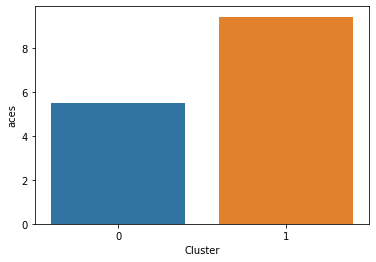

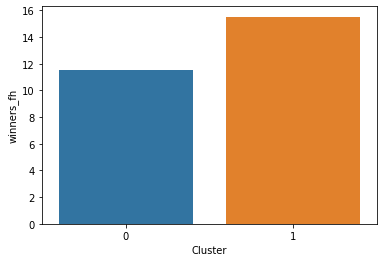

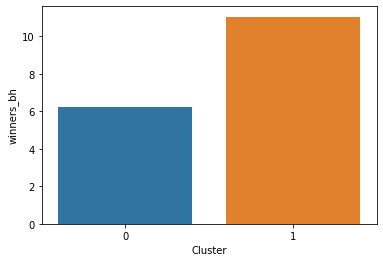

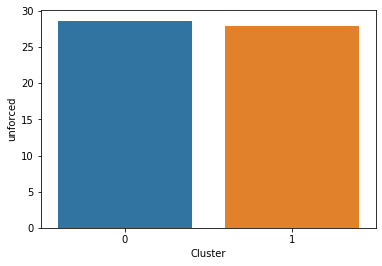

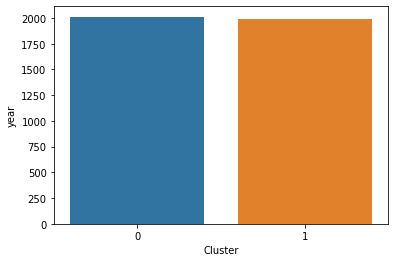

<Figure size 432x288 with 0 Axes>

In [45]:
comparisons=['aces','winners_fh','winners_bh','unforced','year']
for comparison in comparisons:
    #plt.figure(figsize=(8,6))
    sns.barplot(x='Cluster', y=comparison, data=mean_df)
    plt.xlabel("Cluster")
    plt.ylabel(comparison)
    plt.show()
plt.tight_layout()


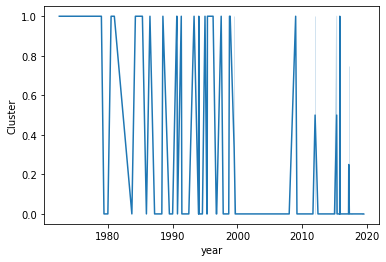

In [46]:
sns.lineplot(y='Cluster', x='year', data=df_merged)

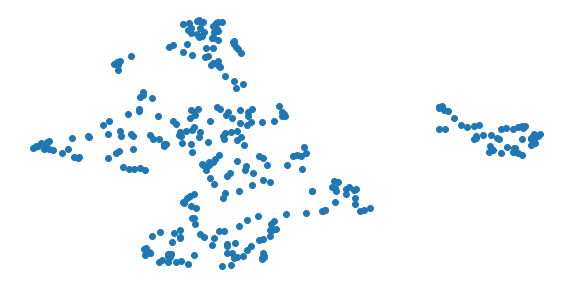

In [49]:
umap_results = umap.UMAP(n_neighbors=5,min_dist=0.1, metric='correlation').fit_transform(df4_std)
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## Looking at the 2 shot patterns data:

In [33]:
scaler=StandardScaler()
df_std=scaler.fit_transform(tabulated_patterns2)
for c in range(2,16):
    agg_cluster=AgglomerativeClustering(n_clusters=c, linkage='ward')
    clusters = agg_cluster.fit_predict(df_std)
    print("The silhoutte score of the {} Agglomerative Clustering solution: {}"
          .format(c,metrics.silhouette_score(df_std, clusters, metric='euclidean')))
    labels = KMeans(n_clusters=c, random_state=1).fit_predict(df_std)
    print("The silhoutte score of the {} KMeans solution: {}"
          .format(c,metrics.silhouette_score(df_std, labels, metric='euclidean')))


The silhoutte score of the 2 Agglomerative Clustering solution: 0.2865988050809096
The silhoutte score of the 2 KMeans solution: 0.2717747559394373
The silhoutte score of the 3 Agglomerative Clustering solution: 0.10903492513539974
The silhoutte score of the 3 KMeans solution: 0.1394026989998416
The silhoutte score of the 4 Agglomerative Clustering solution: 0.11153841196847723
The silhoutte score of the 4 KMeans solution: 0.0870123626957054
The silhoutte score of the 5 Agglomerative Clustering solution: 0.11741672162317067
The silhoutte score of the 5 KMeans solution: 0.08279597406327852
The silhoutte score of the 6 Agglomerative Clustering solution: 0.11765510403973452
The silhoutte score of the 6 KMeans solution: 0.06078205942648037
The silhoutte score of the 7 Agglomerative Clustering solution: 0.11944375450404178
The silhoutte score of the 7 KMeans solution: 0.05077626514339745
The silhoutte score of the 8 Agglomerative Clustering solution: 0.0016016262391695053
The silhoutte scor

Looks like 2 agglomerative clusters was the best again

In [34]:
scaler=StandardScaler()
df_std=scaler.fit_transform(tabulated_patterns2)
agg_cluster=AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters = agg_cluster.fit_predict(df_std)
print("The silhoutte score of the {} Agglomerative Clustering solution: {}"
      .format(2,metrics.silhouette_score(df_std, clusters, metric='euclidean')))

The silhoutte score of the 2 Agglomerative Clustering solution: 0.2865988050809096


In [36]:
tabulated_patterns2['Cluster']=clusters

In [48]:
#merging with summary statistics for anaylsis of the clusters:
df_merged2=tabulated_patterns2.merge(df4, how='left', on='player_id')

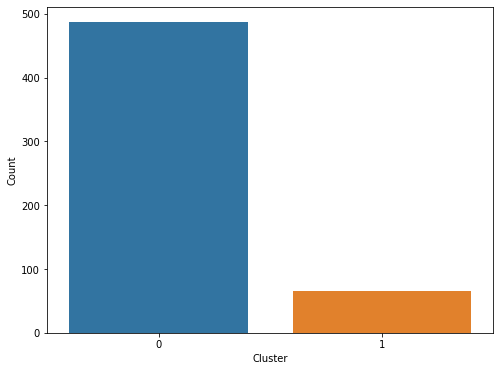

In [35]:
plt.figure(figsize=(8,6))
sns.barplot(data=pd.DataFrame(clusters).value_counts())
plt.ylabel("Count")
plt.xlabel("Cluster")
plt.show()

In [43]:
tabulated_patterns2[tabulated_patterns2['Cluster']==1]

player_patterns2,4*,4b1,4b2,4b3,4d#,4f1,4f2,4f3,4n#,4w#,5b2,5b3,5f1,5f2,5f3,6*,6b2,6b3,6d#,6f1,6f2,6f3,6n#,b1,b1f1,b1f3,b2,b2*,b2b1,b2b2,b2b3,b2f1,b2f2,b2f3,b3,b3*,b3b1,b3b2,b3b3,b3f1,b3f2,b3f3,b3n@,f1,f1*,f1b2,f1b3,f1d@,f1f1,f1f2,f1f3,f1n@,f2,f2*,f2b1,f2b2,f2b3,f2f1,f2f2,f2f3,f3,f3*,f3b1,f3b2,f3b3,f3f1,f3f2,f3f3,Cluster
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albano_Olivetti,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Alessandro_Giannessi,0.095238,0.000000,0.000000,0.000000,0.047619,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.047619,0.047619,0.000000,0.000000,0.047619,0.000000,0.000000,0.142857,0.095238,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,1
Arthur_Cazaux,0.000000,0.052632,0.000000,0.000000,0.105263,0.000000,0.052632,0.052632,0.105263,0.000000,0.000000,0.000000,0.000000,0.052632,0.052632,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.052632,0.052632,0.000000,0.000000,0.210526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Aslan_Karatsev,0.102041,0.000000,0.020408,0.020408,0.020408,0.000000,0.000000,0.000000,0.020408,0.020408,0.000000,0.000000,0.020408,0.000000,0.000000,0.102041,0.000000,0.020408,0.020408,0.020408,0.000000,0.020408,0.020408,0.081633,0.000000,0.000000,0.102041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.102041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.102041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Attila_Balazs,0.109091,0.000000,0.018182,0.000000,0.072727,0.018182,0.000000,0.000000,0.072727,0.036364,0.018182,0.000000,0.018182,0.000000,0.000000,0.218182,0.000000,0.000000,0.072727,0.000000,0.000000,0.000000,0.054545,0.000000,0.000000,0.000000,0.109091,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072727,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Bernabe_Zapata_Miralles,0.085714,0.000000,0.000000,0.028571,0.142857,0.028571,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.057143,0.028571,0.057143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057143,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.171429,0.000000,0.000000,0.000000,0

In [40]:
tabulated_patterns2.groupby('Cluster').mean().style.background_gradient(axis=0)

player_patterns2,4*,4b1,4b2,4b3,4d#,4f1,4f2,4f3,4n#,4w#,5b2,5b3,5f1,5f2,5f3,6*,6b2,6b3,6d#,6f1,6f2,6f3,6n#,b1,b1f1,b1f3,b2,b2*,b2b1,b2b2,b2b3,b2f1,b2f2,b2f3,b3,b3*,b3b1,b3b2,b3b3,b3f1,b3f2,b3f3,b3n@,f1,f1*,f1b2,f1b3,f1d@,f1f1,f1f2,f1f3,f1n@,f2,f2*,f2b1,f2b2,f2b3,f2f1,f2f2,f2f3,f3,f3*,f3b1,f3b2,f3b3,f3f1,f3f2,f3f3
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.021697,0.009017,0.012001,0.016837,0.011594,0.024632,0.015837,0.025878,0.010293,0.006033,0.009338,0.012241,0.016267,0.011176,0.016445,0.023122,0.007887,0.012543,0.009022,0.022862,0.011165,0.024817,0.009064,0.012384,0.009682,0.009256,0.017467,0.007219,0.006983,0.013918,0.016848,0.018922,0.013817,0.014346,0.014392,0.007193,0.013658,0.017308,0.035767,0.023529,0.011012,0.018254,0.007099,0.012643,0.006725,0.010938,0.018505,0.006163,0.029807,0.017874,0.028372,0.006094,0.017320,0.007949,0.007767,0.013690,0.018253,0.016659,0.014000,0.014867,0.013034,0.005411,0.010297,0.011702,0.020912,0.023651,0.010809,0.027736
1,0.081691,0.004480,0.004004,0.006346,0.026271,0.018339,0.006110,0.020019,0.018185,0.012945,0.004554,0.006755,0.008875,0.007704,0.008742,0.081123,0.005348,0.006288,0.014910,0.011400,0.006483,0.010288,0.016242,0.050187,0.004472,0.003283,0.075673,0.020189,0.002992,0.004759,0.005930,0.007274,0.003084,0.006610,0.048938,0.012258,0.004544,0.002716,0.005848,0.008961,0.003034,0.007242,0.002250,0.057401,0.010827,0.002929,0.006769,0.001599,0.008928,0.005463,0.009479,0.004051,0.075051,0.013723,0.004065,0.004768,0.004800,0.008112,0.005595,0.004696,0.056838,0.011746,0.003504,0.003380,0.006091,0.009385,0.004565,0.008890


You can see above that the smaller cluster had a much higher proportion of two shot rallies

In [49]:
#looking at the means with the summary statistics included:
df_merged2.groupby('Cluster').mean().style.background_gradient(axis=0)

,4*,4b1,4b2,4b3,4d#,4f1,4f2,4f3,4n#,4w#,5b2,5b3,5f1,5f2,5f3,6*,6b2,6b3,6d#,6f1,6f2,6f3,6n#,b1,b1f1,b1f3,b2,b2*,b2b1,b2b2,b2b3,b2f1,b2f2,b2f3,b3,b3*,b3b1,b3b2,b3b3,b3f1,b3f2,b3f3,b3n@,f1,f1*,f1b2,f1b3,f1d@,f1f1,f1f2,f1f3,f1n@,f2,f2*,f2b1,f2b2,f2b3,f2f1,f2f2,f2f3,f3,f3*,f3b1,f3b2,f3b3,f3f1,f3f2,f3f3,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,bk_pts,bp_saved,return_pts,return_pts_won,winners,winners_fh,winners_bh,unforced,unforced_fh,unforced_bh,year,first_out,first_make_pct,first_win_pct,first_make_win,second_total,second_make_pct,second_win_pct,second_make_win,second_success
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.021697,0.009017,0.012001,0.016837,0.011594,0.024632,0.015837,0.025878,0.010293,0.006033,0.009338,0.012241,0.016267,0.011176,0.016445,0.023122,0.007887,0.012543,0.009022,0.022862,0.011165,0.024817,0.009064,0.012384,0.009682,0.009256,0.017467,0.007219,0.006983,0.013918,0.016848,0.018922,0.013817,0.014346,0.014392,0.007193,0.013658,0.017308,0.035767,0.023529,0.011012,0.018254,0.007099,0.012643,0.006725,0.010938,0.018505,0.006163,0.029807,0.017874,0.028372,0.006094,0.017320,0.007949,0.007767,0.013690,0.018253,0.016659,0.014000,0.014867,0.013034,0.005411,0.010297,0.011702,0.020912,0.023651,0.010809,0.027736,82.500047,5.453712,2.955843,48.510746,33.371056,31.033458,15.231345,7.557184,4.368273,78.056670,27.530587,24.171601,11.596926,6.349302,28.671770,13.715231,12.000696,2011.729896,33.989301,0.588371,0.686764,0.403920,33.989301,0.913745,0.489332,0.447945,0.183752
1,0.081691,0.004480,0.004004,0.006346,0.026271,0.018339,0.006110,0.020019,0.018185,0.012945,0.004554,0.006755,0.008875,0.007704,0.008742,0.081123,0.005348,0.006288,0.014910,0.011400,0.006483,0.010288,0.016242,0.050187,0.004472,0.003283,0.075673,0.020189,0.002992,0.004759,0.005930,0.007274,0.003084,0.006610,0.048938,0.012258,0.004544,0.002716,0.005848,0.008961,0.003034,0.007242,0.002250,0.057401,0.010827,0.002929,0.006769,0.001599,0.008928,0.005463,0.009479,0.004051,0.075051,0.013723,0.004065,0.004768,0.004800,0.008112,0.005595,0.004696,0.056838,0.011746,0.003504,0.003380,0.006091,0.009385,0.004565,0.008890,106.541528,11.383170,4.848942,60.665592,45.578110,41.026993,20.268084,8.380725,5.482542,99.712058,33.726519,38.772262,15.864785,10.891421,27.848116,10.291654,12.707520,1999.213788,45.875935,0.573735,0.748651,0.428627,45.875935,0.894792,0.488490,0.437001,0.186434


You can see that cluster 1 was once again much older, as well as more likely to hit winners

In [50]:
#TODO: redo analysis only with columns that are longer than 2 characters

Visualizing the clusters:

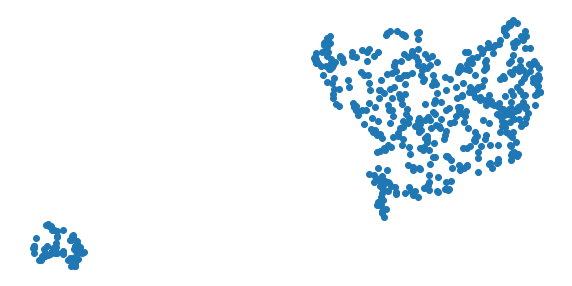

In [44]:
umap_results = umap.UMAP(n_neighbors=5,min_dist=0.1, metric='correlation').fit_transform(tabulated_patterns2)
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

You can see above that the smaller cluster had a much higher proportion of two shot rallies, as well as being mostly composed of older (date-wise) players.